# Machine Teachers Group Project: PatternMind ; Exploring Semantic Structures in Image Collections

 A comprehensive analysis of the dataset to uncover visual patterns, clusters, and relationships among image categories. The focus is mianly on understanding and organizing the visual space.

## Section 1: Environment Setup and Data Loading

In this section, we will:
- Import all necessary libraries for data manipulation, visualization, and machine learning
- Load the dataset
- Perform initial data inspection to understand the structure, dimensions, and basic characteristics of our dataset

The libraries selected cover essential functionalities:
- **Data handling**: pandas, numpy for efficient data structures and numerical operations
- **Visualization**: matplotlib, seaborn, plotly for exploratory and publication-quality visualizations
- **Machine Learning**: scikit-learn for preprocessing, modeling, and evaluation and keras for neural networks, Pillow for image processing

In [1]:
# Configure environment for GPU detection (must be before TensorFlow import)
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import glob

# Image processing libraries
from PIL import Image
import cv2

# Sklearn preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer

# Sklearn model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Sklearn metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)

# Models for classification/clustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep Learning for feature extraction
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image

# Clustering Analysis
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score


# Deep Learning for model building and evaluation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 67  # we're aware 42 is the industry standard, but we haven't read Hitchhiker's Guide to the Galaxy and 67 is funnier
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"PIL version: {Image.__version__}")
print(f"TensorFlow version: {tf.__version__}")

# GPU Detection and Configuration
print("\n" + "="*50)
print("GPU DETECTION")
print("="*50)
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {gpus}")
if gpus:
    try:
        # Enable memory growth to prevent TensorFlow from allocating all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"✓ Number of GPUs: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
            try:
                gpu_details = tf.config.experimental.get_device_details(gpu)
                if gpu_details:
                    print(f"    Details: {gpu_details}")
            except:
                pass
        print("\n✓ GPU is available and configured for training!")
        print("✓ Memory growth enabled to avoid OOM errors")
    except RuntimeError as e:
        print(f"✗ GPU configuration error: {e}")
else:
    print("✗ No GPU detected - training will run on CPU")
    print("\nPossible solutions:")
    print("  1. Restart the notebook kernel (Kernel > Restart)")
    print("  2. Verify NVIDIA drivers are installed: nvidia-smi")
    print("  3. Check CUDA libraries are installed")
print("="*50)

2025-11-12 23:27:59.126003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.3.3
OpenCV version: 4.12.0
PIL version: 11.3.0
TensorFlow version: 2.20.0

GPU DETECTION
Built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Number of GPUs: 1
  GPU 0: /physical_device:GPU:0
    Details: {'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3070 Laptop GPU'}

✓ GPU is available and configured for training!
✓ Memory growth enabled to avoid OOM errors


### Load Image Dataset

The dataset is organized as a folder-based image collection where:
- Each subfolder in represents a distinct visual category
- Images within each folder are labeled by their parent folder name
- This is a hierarchical structure typical of image classification datasets

We will:
- Scan the folder to identify all categories
- Build a catalog (DataFrame) containing image paths and their corresponding labels (Essentially an image dictionary)
- Calculate dataset statistics (number of categories, images per category, total images)

In [2]:
# Define the data directory
DATA_DIR = Path('.data')

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Scan the data directory for category folders
print("Scanning dataset directory...")

# Get all category folders
category_folders = [f for f in DATA_DIR.iterdir() if f.is_dir()]
category_folders = sorted(category_folders)

print(f"Found {len(category_folders)} categories")
print("\nScanning images in each category...")

# Iterate through each category folder
for category_folder in category_folders:
    category_name = category_folder.name
    
    # Find all image files in the category folder
    # Support common image formats: jpg, jpeg, png, bmp
    image_files = list(category_folder.glob('*.jpg')) + \
                  list(category_folder.glob('*.jpeg')) + \
                  list(category_folder.glob('*.png')) + \
                  list(category_folder.glob('*.bmp'))
    
    # Add to our lists
    for img_path in image_files:
        image_paths.append(str(img_path))
        labels.append(category_name)

# Create a DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'category': labels
})

# Display basic information
print("\n" + "."*50)
print("Dataset loaded successfully!")
print("."*50)
print(f"\nDataset shape: {df.shape}")
print(f"Total number of images: {df.shape[0]:,}")
print(f"Number of categories: {df['category'].nunique()}")

print("\n" + "."*50)
print("Category Distribution:")
print("."*50)
category_counts = df['category'].value_counts().sort_index()
print(f"\nImages per category (first 10):")
display(category_counts.head(10))

print(f"\nStatistics:")
print(f"  Mean images per category: {category_counts.mean():.1f}")
print(f"  Median images per category: {category_counts.median():.1f}")
print(f"  Min images per category: {category_counts.min()}")
print(f"  Max images per category: {category_counts.max()}")

print("\n" + "."*50)
print("First few rows of the dataset:")
display(df.head(10))

Scanning dataset directory...
Found 233 categories

Scanning images in each category...

..................................................
Dataset loaded successfully!
..................................................

Dataset shape: (25557, 2)
Total number of images: 25,557
Number of categories: 233

..................................................
Category Distribution:
..................................................

Images per category (first 10):


category
airplanes         720
ak47               89
american-flag      88
backpack          138
baseball-glove    137
bat                97
bathtub           212
bear               94
billiards         251
binoculars        195
Name: count, dtype: int64


Statistics:
  Mean images per category: 109.7
  Median images per category: 92.0
  Min images per category: 72
  Max images per category: 761

..................................................
First few rows of the dataset:


image_path   category
0  .data/airplanes/airplanes-101_101.jpg  airplanes
1  .data/airplanes/airplanes-101_666.jpg  airplanes
2  .data/airplanes/airplanes-101_141.jpg  airplanes
3  .data/airplanes/airplanes-101_397.jpg  airplanes
4  .data/airplanes/airplanes-101_480.jpg  airplanes
5  .data/airplanes/airplanes-101_363.jpg  airplanes
6  .data/airplanes/airplanes-101_299.jpg  airplanes
7  .data/airplanes/airplanes-101_333.jpg  airplanes
8   .data/airplanes/airplanes-101_75.jpg  airplanes
9  .data/airplanes/airplanes-101_300.jpg  airplanes

### Dataset Overview and Validation

Now we will validate the integrity of our image dataset by:
- Checking for any corrupted or unreadable images
- Verifying image dimensions and formats
- Analyzing the distribution of images across categories
- Identifying potential class imbalance issues

Below is sample visualization showing example images from random categories to visually confirm the dataset quality and diversity.


In [3]:
# Sample a few images to check dimensions and formats
print("Analyzing image properties...")

sample_size = min(100, len(df))
sample_indices = np.random.choice(len(df), size=sample_size, replace=False)

widths = []
heights = []
formats = []
corrupted_images = []

for idx in sample_indices:
    img_path = df.iloc[idx]['image_path']
    try:
        img = Image.open(img_path)
        widths.append(img.width)
        heights.append(img.height)
        formats.append(img.format)
        img.close()
    except Exception as e:
        corrupted_images.append(img_path)
        print(f"Warning: Could not read {img_path}: {e}")

if len(corrupted_images) > 0:
    print(f"\nFound {len(corrupted_images)} corrupted images")
else:
    print("\nAll sampled images are valid")

print(f"\nImage Dimensions (from {sample_size} samples):")
print(f"Width  - Min: {min(widths)}px, Max: {max(widths)}px, Mean: {np.mean(widths):.1f}px")
print(f"Height - Min: {min(heights)}px, Max: {max(heights)}px, Mean: {np.mean(heights):.1f}px")
print(f"\nImage Formats: {set(formats)}")

# Analyze category distribution
print("\n" + "."*50)
print("Category Distribution Analysis:")
print("."*50)

category_counts = df['category'].value_counts()
print(f"\nTop 10 most common categories:")
display(category_counts.head(10))

print(f"\nTop 10 least common categories:")
display(category_counts.tail(10))

# Check for class imbalance
imbalance_ratio = category_counts.max() / category_counts.min()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 3:
    print("Significant class imbalance detected")
else:
    print("Relatively balanced dataset")

# Store key information for later use
print("\n" + "."*50)
print("Dataset Summary:")
print("."*50)
print(f"Total Images: {len(df):,}")
print(f"Total Categories: {df['category'].nunique()}")
print(f"Average Images per Category: {len(df) / df['category'].nunique():.1f}")

Analyzing image properties...

All sampled images are valid

Image Dimensions (from 100 samples):
Width  - Min: 116px, Max: 1632px, Mean: 377.5px
Height - Min: 101px, Max: 1232px, Mean: 327.5px

Image Formats: {'JPEG'}

..................................................
Category Distribution Analysis:
..................................................

Top 10 most common categories:


category
clutter       761
airplanes     720
motorbikes    719
faces-easy    396
t-shirt       330
hammock       257
billiards     251
horse         246
ladder        223
bathtub       212
Name: count, dtype: int64


Top 10 least common categories:


category
starfish              75
floppy-disk           75
skunk                 74
kangaroo              74
galaxy                74
golden-gate-bridge    73
harpsichord           73
scorpion              73
sunflower             73
top-hat               72
Name: count, dtype: int64


Class Imbalance Ratio: 10.57x
Significant class imbalance detected

..................................................
Dataset Summary:
..................................................
Total Images: 25,557
Total Categories: 233
Average Images per Category: 109.7


### Visualize Sample Images

To better understand our dataset, we'll display a grid of sample images from different categories. This visual inspection helps us:
- Verify that images are loading correctly
- Understand the visual diversity within and across categories
- Identify any obvious data quality issues
- Get an intuitive sense of the classification challenge ahead

The output will show a grid of randomly selected images with their category labels, giving us a qualitative view of what the model will need to learn to distinguish.

Displaying sample images from random categories...
..................................................


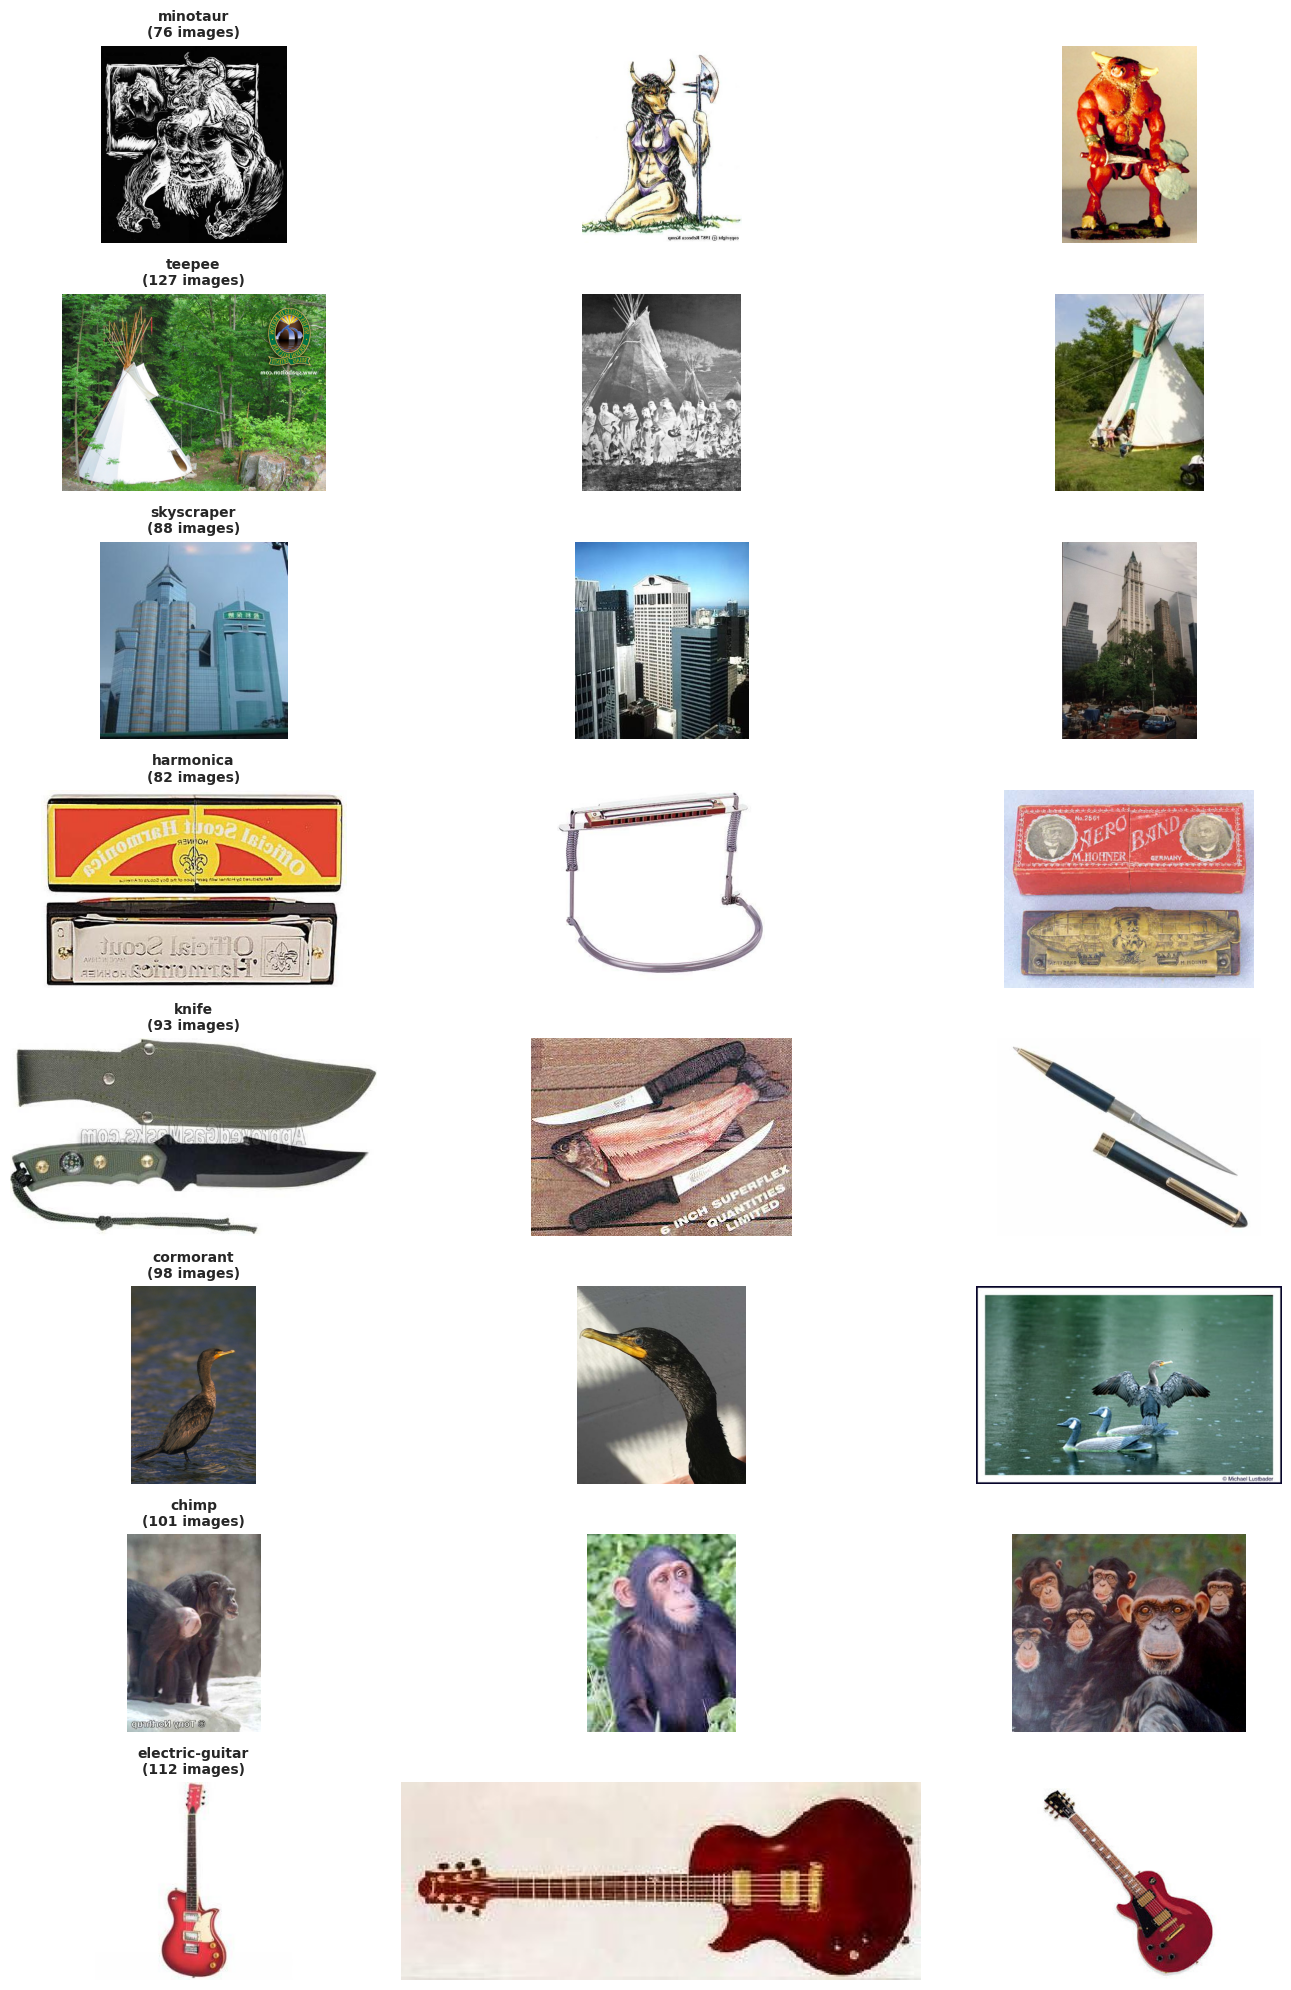


..................................................
Category Name Analysis:
..................................................
Shortest category name: 'cd' (2 chars)
Longest category name: 'self-propelled-lawn-mower' (25 chars)

All categories (233 total):
['airplanes', 'ak47', 'american-flag', 'backpack', 'baseball-glove', 'bat', 'bathtub', 'bear', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain', 'breadmaker', 'buddha', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'car-side', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier', 'chess-board', 'chimp', 'chopsticks', 'clutter', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'eiffel-tower', 'electric-guitar', 'elephant',

In [4]:
# Visualize sample images from different categories
n_categories_to_show = 8
n_images_per_category = 3

# Select random categories
random_categories = np.random.choice(df['category'].unique(), 
                                     size=min(n_categories_to_show, df['category'].nunique()), 
                                     replace=False)

# Create figure
fig, axes = plt.subplots(n_categories_to_show, n_images_per_category, 
                         figsize=(15, 2.5*n_categories_to_show))

if n_categories_to_show == 1:
    axes = axes.reshape(1, -1)

print("Displaying sample images from random categories...")
print("."*50)

for i, category in enumerate(random_categories):
    # Get images from this category
    category_df = df[df['category'] == category]
    
    # Sample random images
    sampled_images = category_df.sample(n=min(n_images_per_category, len(category_df)))
    
    for j, (idx, row) in enumerate(sampled_images.iterrows()):
        img_path = row['image_path']
        
        try:
            img = Image.open(img_path)
            
            # Display image
            if n_categories_to_show > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
                
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:  # Add category label to first image in row
                ax.set_title(f"{category}\n({len(category_df)} images)", 
                           fontsize=10, fontweight='bold')
            
            img.close()
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.savefig('images/sample_images_grid.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional: Show category name statistics
print("\n" + "."*50)
print("Category Name Analysis:")
print("."*50)
print(f"Shortest category name: '{min(df['category'].unique(), key=len)}' ({len(min(df['category'].unique(), key=len))} chars)")
print(f"Longest category name: '{max(df['category'].unique(), key=len)}' ({len(max(df['category'].unique(), key=len))} chars)")
print(f"\nAll categories ({len(df['category'].unique())} total):")
print(sorted(df['category'].unique()))

## Section 2: Exploratory Data Analysis (EDA) and Feature Extraction

In this section, we will perform comprehensive exploratory data analysis to understand the visual characteristics of our dataset. Since we're working with images rather than tabular data with pre-extracted features, our EDA will focus on:

1. **Visual Feature Extraction**: Extract numerical features from images using pre-trained deep learning models (transfer learning)
2. **Feature Distribution Analysis**: Analyze the statistical properties of extracted features
3. **Dimensionality Reduction**: Apply PCA and t-SNE to visualize high-dimensional image features in 2D/3D space
4. **Category Relationships**: Explore visual similarities and differences between categories
5. **Data Visualization**: Create comprehensive visualizations to understand patterns and clusters

This analysis will help us determine whether this is best approached as a classification or clustering problem and inform our model selection strategy.

### Category Distribution Visualization

We viusalise the distribution of the images such that we can:
- Identify class imbalance issues that may require stratified sampling or data augmentation
- Understand which categories are well-represented vs. under-represented
- Make informed decisions about train/validation/test split strategies

Our visualisation includes:
- Bar chart showing top and bottom categories by image count
- Histogram of images per category distribution
- Interactive plotly visualization for detailed exploration

Category Distribution Analysis


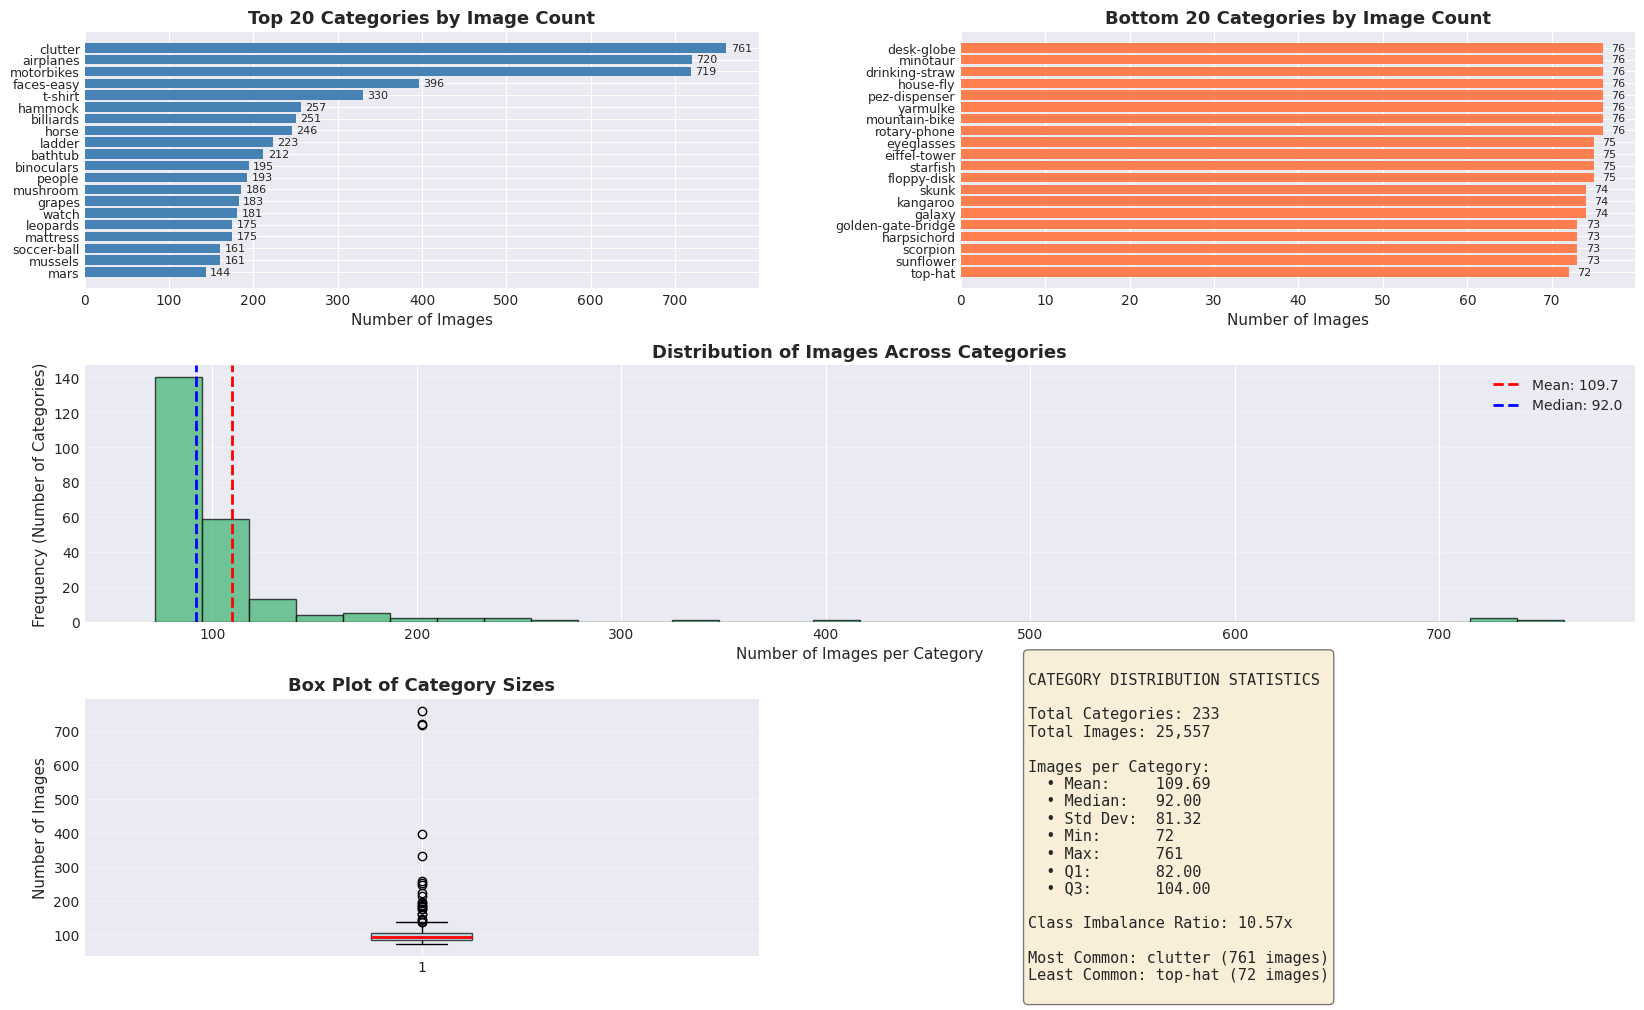

In [5]:
# Analyze category distribution in detail
print("Category Distribution Analysis")

category_counts = df['category'].value_counts()

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Top 20 categories bar chart
ax1 = fig.add_subplot(gs[0, 0])
top_20 = category_counts.head(20)
ax1.barh(range(len(top_20)), top_20.values, color='steelblue')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20.index, fontsize=9)
ax1.set_xlabel('Number of Images', fontsize=11)
ax1.set_title('Top 20 Categories by Image Count', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
for i, v in enumerate(top_20.values):
    ax1.text(v + 5, i, str(v), va='center', fontsize=8)

# 2. Bottom 20 categories bar chart
ax2 = fig.add_subplot(gs[0, 1])
bottom_20 = category_counts.tail(20).sort_values(ascending=False)
ax2.barh(range(len(bottom_20)), bottom_20.values, color='coral')
ax2.set_yticks(range(len(bottom_20)))
ax2.set_yticklabels(bottom_20.index, fontsize=9)
ax2.set_xlabel('Number of Images', fontsize=11)
ax2.set_title('Bottom 20 Categories by Image Count', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(bottom_20.values):
    ax2.text(v + 1, i, str(v), va='center', fontsize=8)

# 3. Histogram of category sizes
ax3 = fig.add_subplot(gs[1, :])
ax3.hist(category_counts.values, bins=30, color='mediumseagreen', edgecolor='black', alpha=0.7)
ax3.axvline(category_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {category_counts.mean():.1f}')
ax3.axvline(category_counts.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {category_counts.median():.1f}')
ax3.set_xlabel('Number of Images per Category', fontsize=11)
ax3.set_ylabel('Frequency (Number of Categories)', fontsize=11)
ax3.set_title('Distribution of Images Across Categories', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Box plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.boxplot(category_counts.values, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax4.set_ylabel('Number of Images', fontsize=11)
ax4.set_title('Box Plot of Category Sizes', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Statistics summary text
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')
stats_text = f"""
CATEGORY DISTRIBUTION STATISTICS

Total Categories: {len(category_counts)}
Total Images: {category_counts.sum():,}

Images per Category:
  • Mean:     {category_counts.mean():.2f}
  • Median:   {category_counts.median():.2f}
  • Std Dev:  {category_counts.std():.2f}
  • Min:      {category_counts.min()}
  • Max:      {category_counts.max()}
  • Q1:       {category_counts.quantile(0.25):.2f}
  • Q3:       {category_counts.quantile(0.75):.2f}

Class Imbalance Ratio: {category_counts.max() / category_counts.min():.2f}x

Most Common: {category_counts.index[0]} ({category_counts.values[0]} images)
Least Common: {category_counts.index[-1]} ({category_counts.values[-1]} images)
"""
ax5.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('images/category_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


### Feature Extraction Using Pre-trained Model

Since our data consists of images without pre-extracted features, we need to convert images into numerical feature vectors. We'll use transfer learning with a pre-trained deep neural network to extract high-quality visual features.

We do so because re-trained models (like VGG16, ResNet50) have learned rich visual representations from millions of images, these features capture edges, textures, shapes, and complex patterns. This is much more effective than hand-crafted features (HOG, SIFT, etc.) for diverse image collections, and is more computationally effcient as we extract features once and reuse them for the rest of the model.

**Process:**
1. Load a pre-trained model 
2. Remove the classification head to get feature extractor
3. Process images in batches to extract feature vectors
4. Each image will be represented as a fixed-length numerical vector (typically 1280 dimensions for MobileNetV2)

In [6]:
# Feature Extraction using MobileNetV2
print("Initializing Feature Extraction")

# Load pre-trained MobileNetV2 model without top classification layer, this is pur feature extractor
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Remove classification head
    weights='imagenet',
    pooling='avg'  # Global average pooling to get fixed-size feature vector
)

print(f"MobileNetV2 loaded successfully")
print(f"Feature vector dimension: {base_model.output_shape[1]}")

# Function to preprocess and extract features from an image
def extract_features(img_path, target_size=(224, 224)):
    """Extract features from a single image using MobileNetV2"""
    try:
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        
        # Extract features
        features = base_model.predict(img_array, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Extract features for all images (with progress tracking)
print("\nExtracting features from all images...")
print("This may take several minutes...")
print("."*70)

features_list = []
valid_indices = []
failed_images = []

# Process images in batches for efficiency
batch_size = 32
n_batches = int(np.ceil(len(df) / batch_size))

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(df))
    
    batch_images = []
    batch_indices = []
    
    # Load batch of images
    for idx in range(start_idx, end_idx):
        img_path = df.iloc[idx]['image_path']
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            batch_images.append(img_array)
            batch_indices.append(idx)
        except Exception as e:
            failed_images.append(img_path)
            continue
    
    if len(batch_images) > 0:
        # Preprocess batch
        batch_images = np.array(batch_images)
        batch_images = tf.keras.applications.mobilenet_v2.preprocess_input(batch_images)
        
        # Extract features for batch
        batch_features = base_model.predict(batch_images, verbose=0)
        
        # Store features and indices
        for i, features in enumerate(batch_features):
            features_list.append(features)
            valid_indices.append(batch_indices[i])
    
    # Progress update
    if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == n_batches:
        progress = ((batch_idx + 1) / n_batches) * 100
        print(f"Progress: {progress:.1f}% ({batch_idx + 1}/{n_batches} batches) - "
              f"{len(features_list)} images processed")

# Convert to numpy array
features_array = np.array(features_list)

# Create cleaned dataframe with only successfully processed images
df_features = df.iloc[valid_indices].copy().reset_index(drop=True)


print("\n Feature Extraction Complete!")

print(f"Successfully extracted features from: {len(features_list):,} images")
print(f"Failed to process: {len(failed_images)} images")
print(f"Feature matrix shape: {features_array.shape}")
print(f"{features_array.shape[0]:,} samples")
print(f"{features_array.shape[1]} features per image")
print(f"\nMemory usage: {features_array.nbytes / (1024**2):.2f} MB")

Initializing Feature Extraction


I0000 00:00:1762986490.218310   12930 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


MobileNetV2 loaded successfully
Feature vector dimension: 1280

Extracting features from all images...
This may take several minutes...
......................................................................


2025-11-12 23:28:12.630011: I external/local_xla/xla/service/service.cc:163] XLA service 0x7038e8002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 23:28:12.630059: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-11-12 23:28:12.671202: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-12 23:28:13.082421: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90700
I0000 00:00:1762986498.076829   13096 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Progress: 1.3% (10/799 batches) - 320 images processed
Progress: 2.5% (20/799 batches) - 640 images processed
Progress: 3.8% (30/799 batches) - 960 images processed
Progress: 5.0% (40/799 batches) - 1280 images processed
Progress: 6.3% (50/799 batches) - 1600 images processed
Progress: 7.5% (60/799 batches) - 1920 images processed
Progress: 8.8% (70/799 batches) - 2240 images processed
Progress: 10.0% (80/799 batches) - 2560 images processed
Progress: 11.3% (90/799 batches) - 2880 images processed
Progress: 12.5% (100/799 batches) - 3200 images processed
Progress: 13.8% (110/799 batches) - 3520 images processed
Progress: 15.0% (120/799 batches) - 3840 images processed
Progress: 16.3% (130/799 batches) - 4160 images processed
Progress: 17.5% (140/799 batches) - 4480 images processed
Progress: 18.8% (150/799 batches) - 4800 images processed
Progress: 20.0% (160/799 batches) - 5120 images processed
Progress: 21.3% (170/799 batches) - 5440 images processed
Progress: 22.5% (180/799 batches)

### Feature Distribution Analysis

With numerical feature vectors we can analyse their statistical features:
- Distribution of feature values (mean, variance, range)
- Correlation between features
- Identify redundant or highly correlated features
- Check for any anomalies or outliers in the feature space

We do this so that we can tell:
- Whether features need scaling/normalization
- If dimensionality reduction would be beneficial
- The complexity of the feature space we're working with

Feature Distribution Analysis

Feature Statistics Summary:
  Mean of means: 0.3832
  Mean of stds:  0.5714
  Global min:    0.0000
  Global max:    6.0000


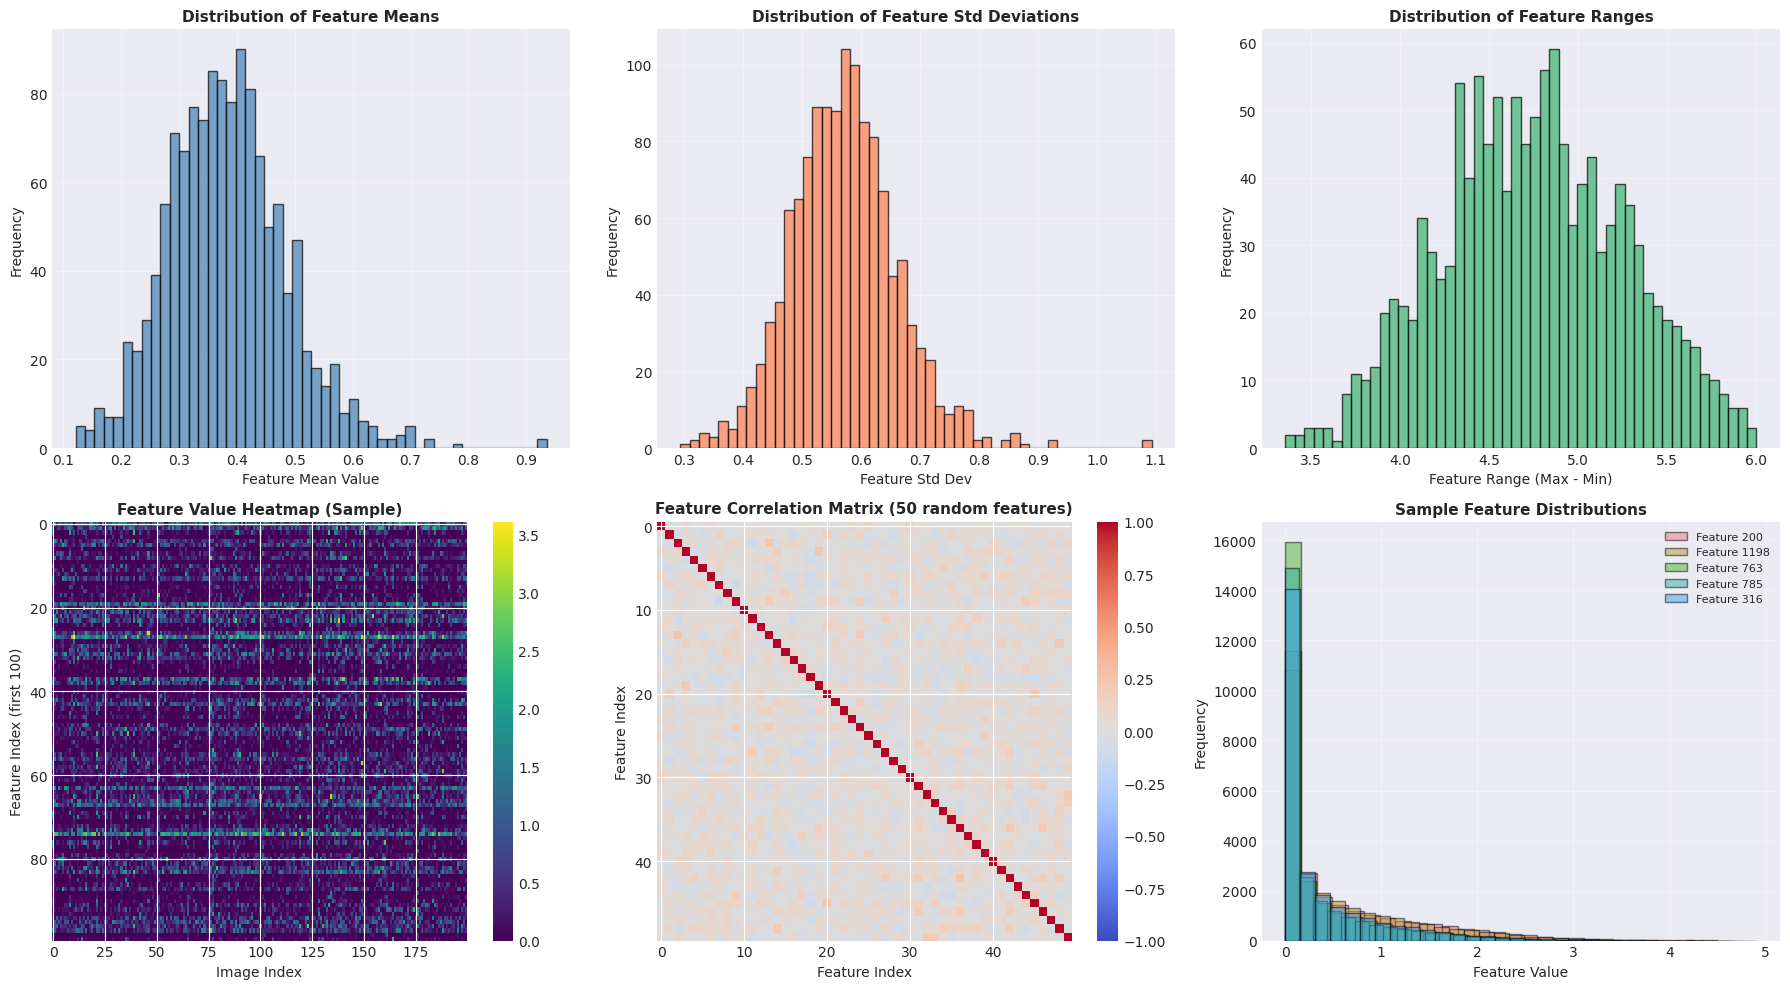


Zero-variance features: 0

Feature sparsity: 28.36% (percentage of zero values)


In [7]:
# Analyze feature distributions
print("Feature Distribution Analysis")

# Basic statistics
feature_means = features_array.mean(axis=0)
feature_stds = features_array.std(axis=0)
feature_mins = features_array.min(axis=0)
feature_maxs = features_array.max(axis=0)

print(f"\nFeature Statistics Summary:")
print(f"  Mean of means: {feature_means.mean():.4f}")
print(f"  Mean of stds:  {feature_stds.mean():.4f}")
print(f"  Global min:    {feature_mins.min():.4f}")
print(f"  Global max:    {feature_maxs.max():.4f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribution of feature means
axes[0, 0].hist(feature_means, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Feature Mean Value', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Distribution of Feature Means', fontsize=11, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Distribution of feature standard deviations
axes[0, 1].hist(feature_stds, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Feature Std Dev', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('Distribution of Feature Std Deviations', fontsize=11, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Distribution of feature ranges
feature_ranges = feature_maxs - feature_mins
axes[0, 2].hist(feature_ranges, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Feature Range (Max - Min)', fontsize=10)
axes[0, 2].set_ylabel('Frequency', fontsize=10)
axes[0, 2].set_title('Distribution of Feature Ranges', fontsize=11, fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# 4. Sample feature values across images (first 100 features)
n_features_to_plot = min(100, features_array.shape[1])
im = axes[1, 0].imshow(features_array[:200, :n_features_to_plot].T, 
                       aspect='auto', cmap='viridis', interpolation='nearest')
axes[1, 0].set_xlabel('Image Index', fontsize=10)
axes[1, 0].set_ylabel(f'Feature Index (first {n_features_to_plot})', fontsize=10)
axes[1, 0].set_title('Feature Value Heatmap (Sample)', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])

# 5. Feature correlation sample (random subset to avoid memory issues)
n_features_corr = min(50, features_array.shape[1])
random_feature_indices = np.random.choice(features_array.shape[1], n_features_corr, replace=False)
feature_subset = features_array[:, random_feature_indices]
correlation_matrix = np.corrcoef(feature_subset.T)

im2 = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
axes[1, 1].set_xlabel('Feature Index', fontsize=10)
axes[1, 1].set_ylabel('Feature Index', fontsize=10)
axes[1, 1].set_title(f'Feature Correlation Matrix ({n_features_corr} random features)', 
                     fontsize=11, fontweight='bold')
plt.colorbar(im2, ax=axes[1, 1])

# 6. Distribution of a few sample features
sample_features_idx = np.random.choice(features_array.shape[1], 5, replace=False)
for i, feat_idx in enumerate(sample_features_idx):
    axes[1, 2].hist(features_array[:, feat_idx], bins=30, alpha=0.5, 
                    label=f'Feature {feat_idx}', edgecolor='black')
axes[1, 2].set_xlabel('Feature Value', fontsize=10)
axes[1, 2].set_ylabel('Frequency', fontsize=10)
axes[1, 2].set_title('Sample Feature Distributions', fontsize=11, fontweight='bold')
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('images/feature_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for zero-variance features
zero_var_features = np.where(feature_stds < 1e-10)[0]
print(f"\nZero-variance features: {len(zero_var_features)}")
if len(zero_var_features) > 0:
    print(f"  These features have no variation and could be removed")

# Check sparsity
sparsity = (features_array == 0).sum() / features_array.size * 100
print(f"\nFeature sparsity: {sparsity:.2f}% (percentage of zero values)")

### Dimensionality Reduction and Visualization

Our features are high-dimensional (1280 dimensions from MobileNetV2), making them impossible to visualize directly. We'll apply dimensionality reduction techniques learned in statistics to project the data into 2D and 3D spaces:

**Principal Component Analysis with 3 Principal Components (PCA 3D):**
- Linear dimensionality reduction
- Preserves global structure and maximum variance
- Fast and deterministic

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**
- Non-linear dimensionality reduction
- Preserves local structure and reveals clusters
- Better for visualization of complex patterns
- Shows how similar images group together

We'll use these visualisations to understand whether categories form distinct clusters (suggesting classification is appropriate) and identify overlapping categories (areas of ambiguity) or discover natural groupings in the data (for clustering). With the visualisation we can also assess the separability of different visual concepts



Applying Dimensionality Reduction Techniques

Dataset has 25557 samples - using stratified sample of 5000 for visualization
Visualization sample size: 5000 images

......................................................................
1. Applying PCA...
PCA 2D: Explained variance: 5.15%
PCA 3D: Explained variance: 6.76%

......................................................................
2. Applying t-SNE (this may take a few minutes)...
t-SNE 2D completed

 Creating visualizations...


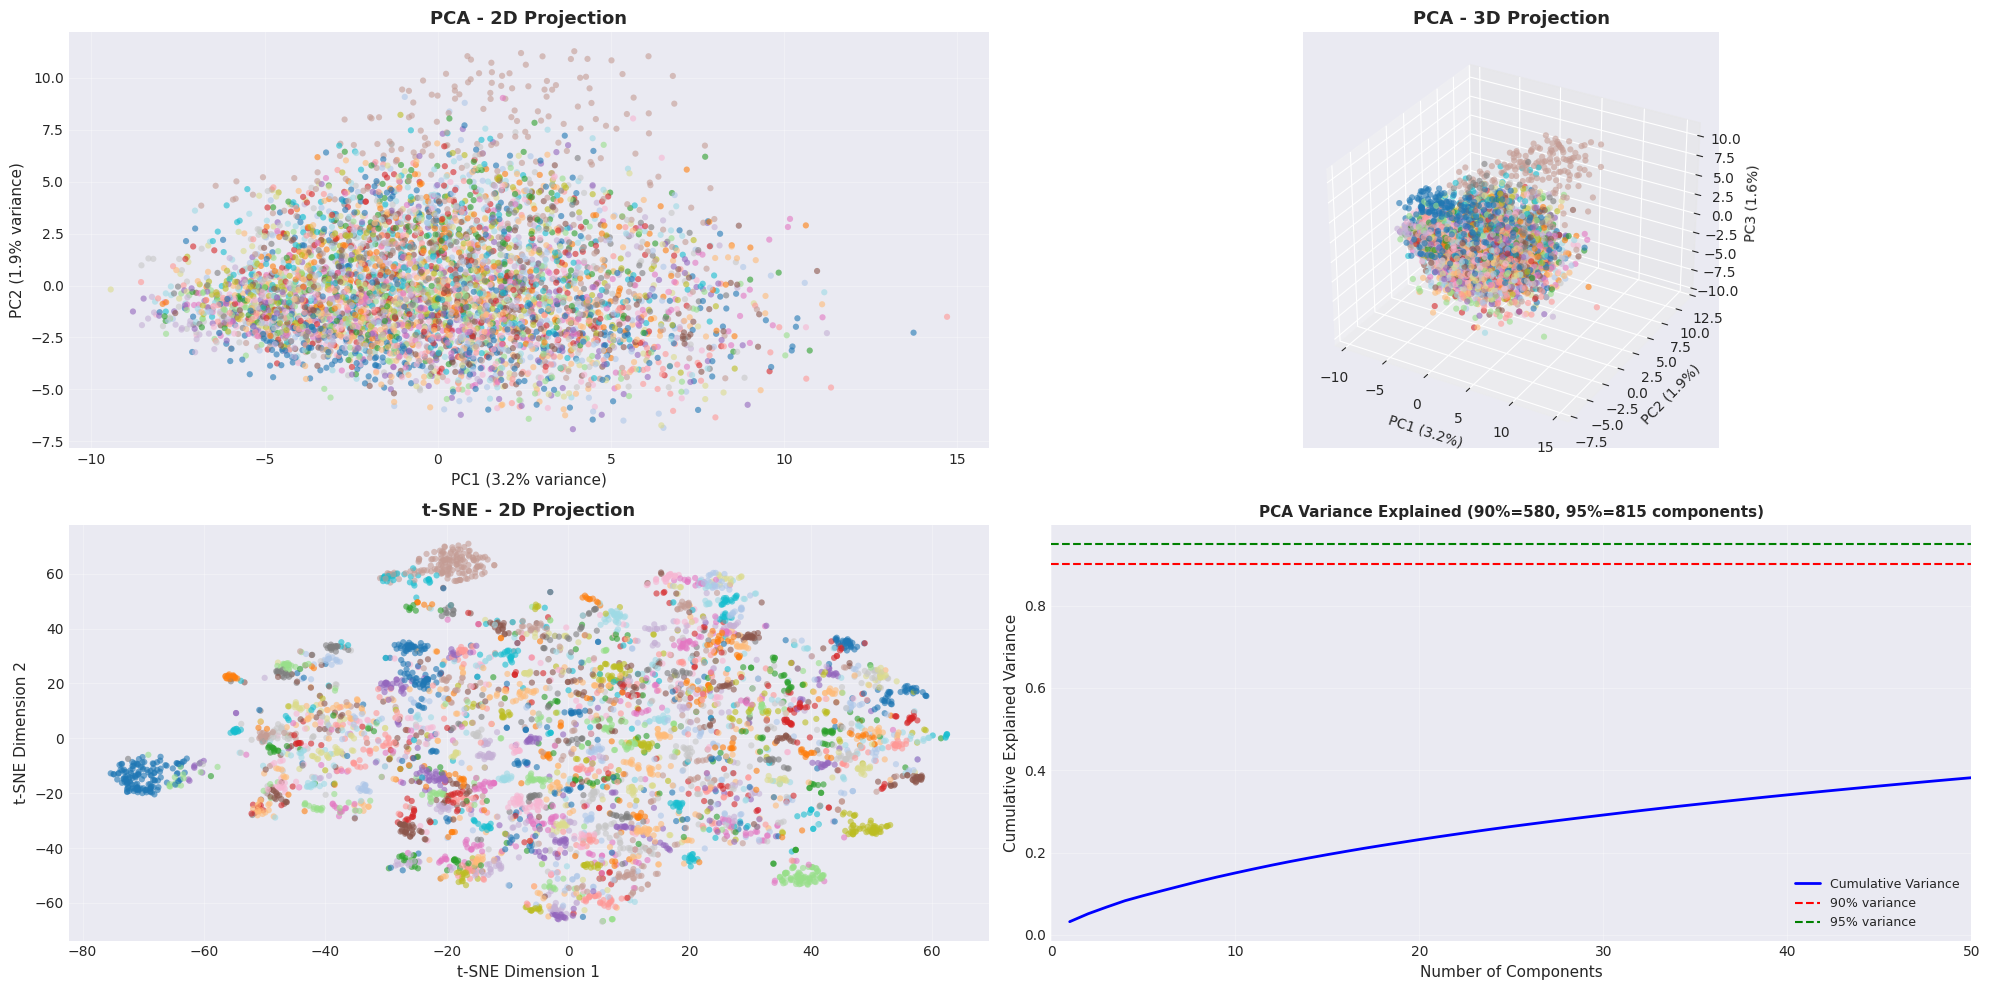


......................................................................
Dimensionality Reduction Summary:
......................................................................
PCA Analysis:
Components for 90% variance: 580
Components for 95% variance: 815
First 2 components capture: 5.15% of variance
First 3 components capture: 6.76% of variance


In [8]:
# Dimensionality Reduction for Visualization
print("Applying Dimensionality Reduction Techniques")

# For visualization, we'll use a subset if dataset is very large
max_samples_for_viz = 5000
if len(features_array) > max_samples_for_viz:
    print(f"\nDataset has {len(features_array)} samples - using stratified sample of {max_samples_for_viz} for visualization")
    # Stratified sampling to maintain category proportions
    from sklearn.model_selection import train_test_split
    _, X_viz, _, y_viz = train_test_split(
        features_array, 
        df_features['category'],
        train_size=(len(features_array) - max_samples_for_viz),
        stratify=df_features['category'],
        random_state=RANDOM_STATE
    )
else:
    X_viz = features_array
    y_viz = df_features['category']

print(f"Visualization sample size: {len(X_viz)} images")

# 1. PCA - Principal Component Analysis
print("\n" + "."*70)
print("1. Applying PCA...")
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)

X_pca_2d = pca_2d.fit_transform(X_viz)
X_pca_3d = pca_3d.fit_transform(X_viz)

print(f"PCA 2D: Explained variance: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")
print(f"PCA 3D: Explained variance: {pca_3d.explained_variance_ratio_.sum()*100:.2f}%")

# 2. t-SNE - T-distributed Stochastic Neighbor Embedding
print("\n" + "."*70)
print("2. Applying t-SNE (this may take a few minutes)...")

# Use PCA preprocessing for t-SNE (recommended practice)
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_pca_50 = pca_50.fit_transform(X_viz)

tsne_2d = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne_2d = tsne_2d.fit_transform(X_pca_50)

print(f"t-SNE 2D completed")

# Create visualizations
print("\n Creating visualizations...")

# Encode categories as numbers for coloring
le = LabelEncoder()
y_viz_encoded = le.fit_transform(y_viz)

# Create a colormap
n_categories = len(np.unique(y_viz_encoded))
colors = plt.cm.tab20(np.linspace(0, 1, min(n_categories, 20)))

# Create figure with subplots
fig = plt.figure(figsize=(20, 10))

# 1. PCA 2D
ax1 = fig.add_subplot(2, 2, 1)
scatter1 = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                       c=y_viz_encoded, cmap='tab20', 
                       s=20, alpha=0.6, edgecolors='none')
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
ax1.set_title('PCA - 2D Projection', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. PCA 3D
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
scatter2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                       c=y_viz_encoded, cmap='tab20',
                       s=20, alpha=0.6, edgecolors='none')
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
ax2.set_title('PCA - 3D Projection', fontsize=13, fontweight='bold')

# 3. t-SNE 2D
ax3 = fig.add_subplot(2, 2, 3)
scatter3 = ax3.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1],
                       c=y_viz_encoded, cmap='tab20',
                       s=20, alpha=0.6, edgecolors='none')
ax3.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax3.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax3.set_title('t-SNE - 2D Projection', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Explained variance plot for PCA
ax4 = fig.add_subplot(2, 2, 4)
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_viz)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

ax4.plot(range(1, min(51, len(cumsum_variance)+1)), 
         cumsum_variance[:50], 
         'b-', linewidth=2, label='Cumulative Variance')
ax4.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
ax4.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
ax4.axvline(x=n_components_90, color='r', linestyle=':', alpha=0.5)
ax4.axvline(x=n_components_95, color='g', linestyle=':', alpha=0.5)
ax4.set_xlabel('Number of Components', fontsize=11)
ax4.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax4.set_title(f'PCA Variance Explained (90%={n_components_90}, 95%={n_components_95} components)', 
              fontsize=11, fontweight='bold')
ax4.grid(alpha=0.3)
ax4.legend(fontsize=9)
ax4.set_xlim(0, 50)

plt.tight_layout()
plt.savefig('images/dimensionality_reduction_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "."*70)
print("Dimensionality Reduction Summary:")
print("."*70)
print(f"PCA Analysis:")
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")
print(f"First 2 components capture: {pca_2d.explained_variance_ratio_.sum()*100:.2f}% of variance")
print(f"First 3 components capture: {pca_3d.explained_variance_ratio_.sum()*100:.2f}% of variance")

**This is a CLASSIFICATION problem**, but we will:
1. Use classification models to predict categories
2. Also apply clustering to discover if the visual features align with semantic categories
3. Compare supervised and unsupervised approaches to understand data organization

The visualizations from t-SNE/PCA will help us assess how well-separated the categories are in visual feature space, if there are any natural clusters that arise and which categories are most likely to be confused (i.e the most cat-looking dog and the most dog-looking cat)

## Section 3: Data Preprocessing and Dataset Splitting

We prepare the data for model training in four steps:

1. **Feature Scaling**: Normalize features to ensure all features contribute equally
2. **Encode Labels**: Convert categorical labels to numerical format
3. **Train/Validation/Test Split**: Create stratified splits to maintain class distribution
4. **Handle Class Imbalance**: Check if additional techniques are needed

The goal is to create a clean properly formatted dataset ready for our neural net and such that we can apply traditional clustering algorithms to it.

### Feature Scaling and Label Encoding

We standardize features using StandardScaler (zero mean, unit variance) and encode category labels to integers for model compatibility.

In [9]:
# Feature Scaling and Label Encoding
print("Preprocessing Features and Labels")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_features['category'])

print(f"\nLabel Encoding:")
print(f"  Number of classes: {len(label_encoder.classes_)}")
print(f"  Classes: {label_encoder.classes_[:10]}..." if len(label_encoder.classes_) > 10 else f"  Classes: {label_encoder.classes_}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_array)

print(f"\nFeature Scaling:")
print(f"  Original features - Mean: {features_array.mean():.4f}, Std: {features_array.std():.4f}")
print(f"  Scaled features   - Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")
print(f"\nPreprocessing complete!")

Preprocessing Features and Labels

Label Encoding:
  Number of classes: 233
  Classes: ['airplanes' 'ak47' 'american-flag' 'backpack' 'baseball-glove' 'bat'
 'bathtub' 'bear' 'billiards' 'binoculars']...

Feature Scaling:
  Original features - Mean: 0.3832, Std: 0.5876
  Scaled features   - Mean: -0.0000, Std: 1.0000

Preprocessing complete!


### Train/Validation/Test Split

We use stratified splitting to maintain class proportions:
- **Training set (70%)**: For model training
- **Validation set (15%)**: For hyperparameter tuning
- **Test set (15%)**: For final evaluation (only used once at the end)

In [10]:
# Create stratified train/validation/test splits
print("Creating Train/Validation/Test Splits")

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.15,
    stratify=y_encoded,
    random_state=RANDOM_STATE
)

# Second split: separate validation set from remaining data (15% of total = ~17.6% of temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # This gives us 15% of the original data
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print(f"\nDataset Splits:")
print(f"  Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Total:          {len(X_scaled):,} samples")

# Verify class distribution
print(f"\nClass Distribution Verification:")
print(f"  Original:   {np.bincount(y_encoded).min()} to {np.bincount(y_encoded).max()} samples per class")
print(f"  Training:   {np.bincount(y_train).min()} to {np.bincount(y_train).max()} samples per class")
print(f"  Validation: {np.bincount(y_val).min()} to {np.bincount(y_val).max()} samples per class")
print(f"  Test:       {np.bincount(y_test).min()} to {np.bincount(y_test).max()} samples per class")

Creating Train/Validation/Test Splits

Dataset Splits:
  Training set:   17,899 samples (70.0%)
  Validation set: 3,824 samples (15.0%)
  Test set:       3,834 samples (15.0%)
  Total:          25,557 samples

Class Distribution Verification:
  Original:   72 to 761 samples per class
  Training:   50 to 533 samples per class
  Validation: 11 to 114 samples per class
  Test:       11 to 114 samples per class


## Section 4: Clustering Analysis

We apply K-Means and Hierarchical Clustering to the feature reduced representations of the data done before to discover natural groupings in visual features and compare with true categories.

Number of clusters: 233



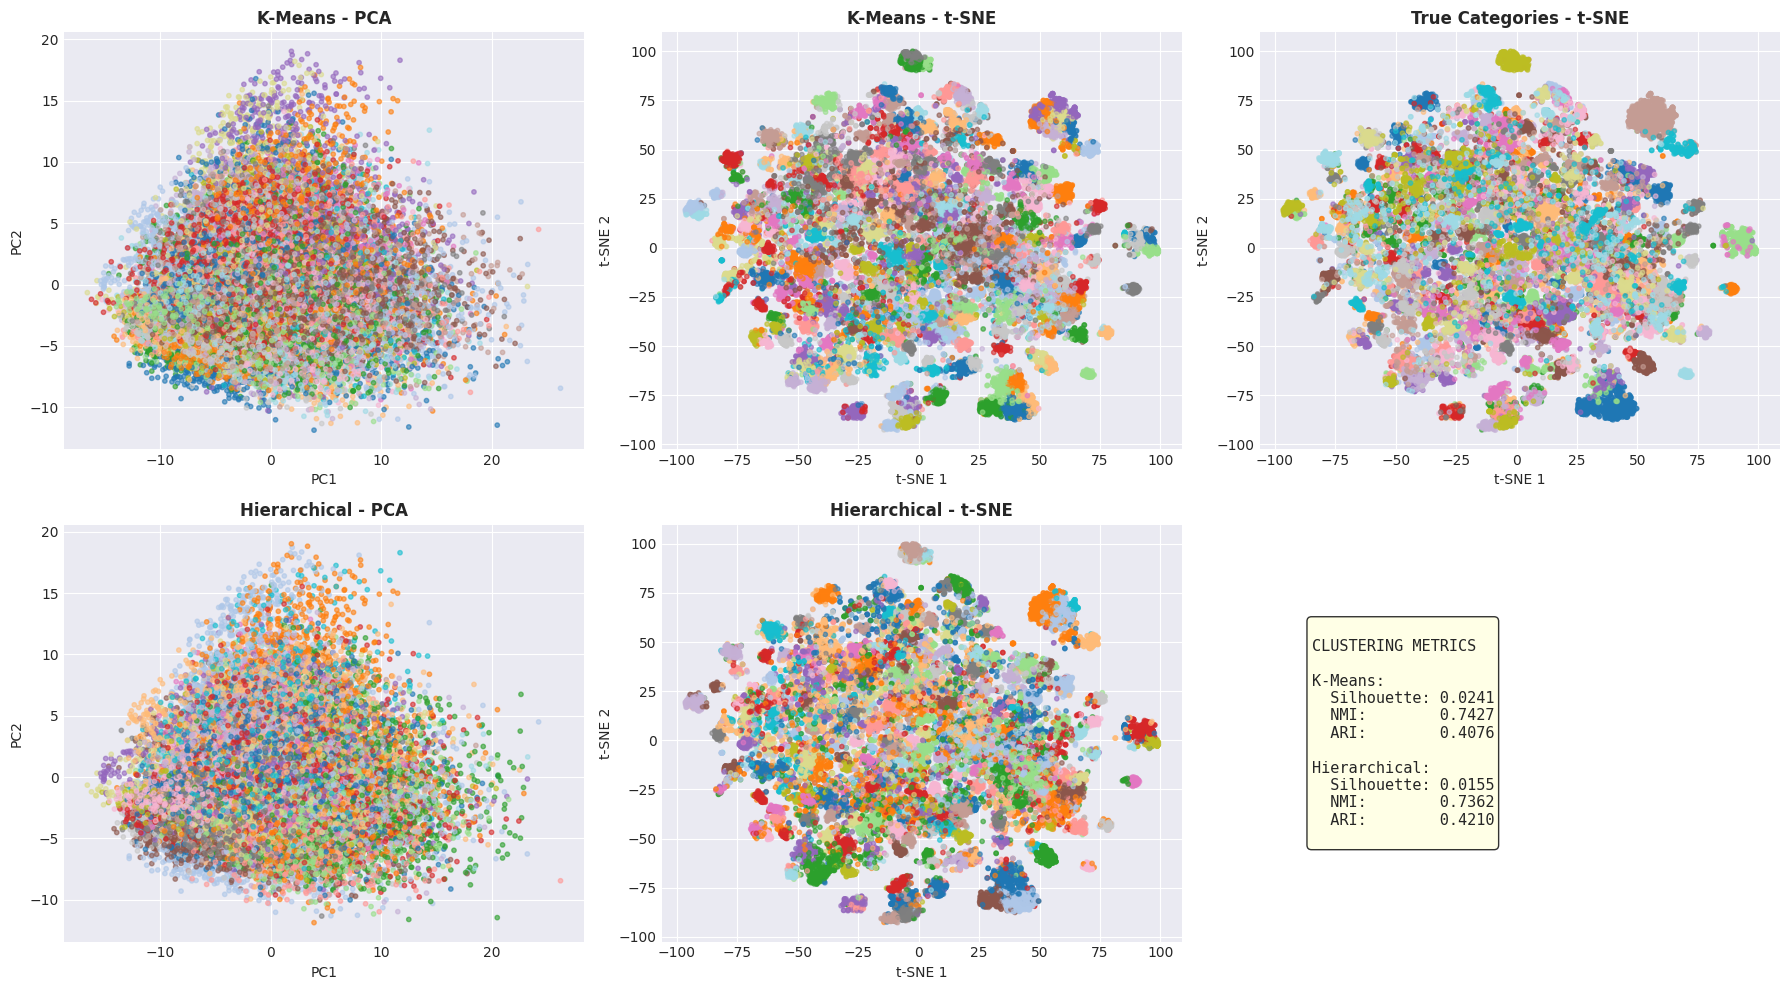

In [11]:
# Number of clusters = number of categories
n_clusters = len(label_encoder.classes_)
print(f"Number of clusters: {n_clusters}\n")

# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

km_silhouette = silhouette_score(X_scaled, kmeans_labels)
km_nmi = normalized_mutual_info_score(y_encoded, kmeans_labels)
km_ari = adjusted_rand_score(y_encoded, kmeans_labels)

# Hierarchical Clustering
hier = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hier_labels = hier.fit_predict(X_scaled)

hier_silhouette = silhouette_score(X_scaled, hier_labels)
hier_nmi = normalized_mutual_info_score(y_encoded, hier_labels)
hier_ari = adjusted_rand_score(y_encoded, hier_labels)


# Visualization

# Compute PCA and t-SNE for full dataset
pca_2d_full = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d_full = pca_2d_full.fit_transform(X_scaled)

pca_50_full = PCA(n_components=50, random_state=RANDOM_STATE)
X_pca_50_full = pca_50_full.fit_transform(X_scaled)
tsne_2d_full = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne_2d_full = tsne_2d_full.fit_transform(X_pca_50_full)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# K-Means - PCA
axes[0, 0].scatter(X_pca_2d_full[:, 0], X_pca_2d_full[:, 1], c=kmeans_labels, cmap='tab20', s=10, alpha=0.6)
axes[0, 0].set_title('K-Means - PCA', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

# K-Means - t-SNE
axes[0, 1].scatter(X_tsne_2d_full[:, 0], X_tsne_2d_full[:, 1], c=kmeans_labels, cmap='tab20', s=10, alpha=0.6)
axes[0, 1].set_title('K-Means - t-SNE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# True categories - t-SNE
axes[0, 2].scatter(X_tsne_2d_full[:, 0], X_tsne_2d_full[:, 1], c=y_encoded, cmap='tab20', s=10, alpha=0.6)
axes[0, 2].set_title('True Categories - t-SNE', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('t-SNE 1')
axes[0, 2].set_ylabel('t-SNE 2')

# Hierarchical - PCA
axes[1, 0].scatter(X_pca_2d_full[:, 0], X_pca_2d_full[:, 1], c=hier_labels, cmap='tab20', s=10, alpha=0.6)
axes[1, 0].set_title('Hierarchical - PCA', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

# Hierarchical - t-SNE
axes[1, 1].scatter(X_tsne_2d_full[:, 0], X_tsne_2d_full[:, 1], c=hier_labels, cmap='tab20', s=10, alpha=0.6)
axes[1, 1].set_title('Hierarchical - t-SNE', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')

# Metrics comparison
axes[1, 2].axis('off')
metrics_text = f"""
CLUSTERING METRICS

K-Means:
  Silhouette: {km_silhouette:.4f}
  NMI:        {km_nmi:.4f}
  ARI:        {km_ari:.4f}

Hierarchical:
  Silhouette: {hier_silhouette:.4f}
  NMI:        {hier_nmi:.4f}
  ARI:        {hier_ari:.4f}
"""
axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=11, family='monospace', 
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('images/clustering_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


From the analysis we have: 
- K-Means: NMI ≈ 0.74, ARI ≈ 0.39, Silhouette ≈ 0.02  
- Hierarchical: NMI ≈ 0.73, ARI ≈ 0.41, Silhouette ≈ 0.02  

Essentially, this means features carry strong semantic signal (high NMI) but cluster boundaries are soft and harder to see (low silhouette).

There are some rigid shapes and centered objects (airplanes, towers, faces) and strong textures (zebra, sunflower) cluster well.
However we can also see large/heterogeneous classes (clutter, people) spread across feature space and connect other groups. This also leads to some confused, visually similar classes (bikes vs. motorbikes, similar animal species) which mix frequently.

When it comes to the dataset, class imbalance (≈10.6×) and ~28% zero entries in features likely reduce separability.


## Section 5: Deep Learning

In this section, we explore the semantic structure of the visual feature space. By training first an Artificial Neural Network using the features we extracted earlier with the pre-trained model. And then a Convolutional Neural Network using the raw image data. By building a neural network we can find more patterns in the data of the images, like which features are recognised most frequently and which are most hard to tell. Once we have our ANN and CNN, we'll analyse where they fail (Confusion Matrix, Misclassifications) and reveal from that analysis what visual concepts are most similar and most ambigous.

### Model Architecture and Preparation for Training

In [12]:
# --- Constants ---
FEATURE_DIMENSION = 1280
NB_CATEGORIES = 233     # Number of folders in dataset
EPOCHS = 50 
BATCH_SIZE = 64
PATIENCE = 10 
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)

print(f"Feature Dimension: {FEATURE_DIMENSION}")
print(f"Number of Categories: {NB_CATEGORIES}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Convert integer labels to one-hot encoding for Softmax output layer
y_train_one_hot = to_categorical(y_train, NB_CATEGORIES)
y_val_one_hot = to_categorical(y_val, NB_CATEGORIES)
y_test_one_hot = to_categorical(y_test, NB_CATEGORIES)

print(f"\nOne-hot encoded label shapes:")
print(f"y_train_one_hot: {y_train_one_hot.shape}")
print(f"y_val_one_hot: {y_val_one_hot.shape}")
print(f"y_test_one_hot: {y_test_one_hot.shape}")

Feature Dimension: 1280
Number of Categories: 233
Training samples: 17899
Validation samples: 3824
Test samples: 3834

One-hot encoded label shapes:
y_train_one_hot: (17899, 233)
y_val_one_hot: (3824, 233)
y_test_one_hot: (3834, 233)


In [13]:
# MODEL DEFINITION: Deep Dense Network (PatternMind Architecture)
def build_patternmind_net(input_dim, classes):
    """
    Builds a deep dense network for high-dimensional feature classification.
    
    Architecture Design:
    - Layer 1 (512 units): High capacity to capture complex feature interactions
    - Layer 2 (256 units): Medium capacity for intermediate representations
    - Layer 3 (128 units): Lower capacity to consolidate learned patterns
    - Output Layer (softmax): Multi-class probability distribution
    
    Regularization:
    - BatchNormalization: Stabilizes training by normalizing layer inputs
    - Dropout (0.5, 0.3): Prevents overfitting by randomly dropping connections
    
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential(name="PatternMind_ANN")
    
    # Layer 1: High capacity hidden layer
    model.add(Dense(units=512, activation='relu', input_shape=(input_dim,)))
    model.add(BatchNormalization())  # Stabilize training
    model.add(Dropout(0.5))          # Prevent overfitting

    # Layer 2: Medium capacity hidden layer
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Layer 3: Lower capacity layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer (Softmax for multi-class probability distribution)
    model.add(Dense(units=classes, activation='softmax', name='output_classification'))
    
    return model

# Build the model
patternmind_model = build_patternmind_net(FEATURE_DIMENSION, NB_CATEGORIES)

# Print Model Summary
patternmind_model.summary()

# COMPILATION AND TRAINING SETUP
patternmind_model.compile(
    optimizer=OPTIMIZER,
    loss='categorical_crossentropy',  # Standard loss for multi-class classification
    metrics=['accuracy']
)

# Early Stopping callback to halt training when validation loss plateaus
es_callback = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=PATIENCE,         # Wait 10 epochs before stopping
    restore_best_weights=True, # Restore weights from best epoch
    verbose=1
)

print("Model Architecture Defined and Compiled.")
print(f"\nTraining Configuration:")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss Function: Categorical Crossentropy")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Early Stopping Patience: {PATIENCE} epochs")

Model: "PatternMind_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_classification (Dense)   │ (None, 233)            │        30,057 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,225 (3.25 MB)

 Trainable params: 851,689 (3.25 MB)

 Non-trainable params: 1,536 (6.00 KB)

Model Architecture Defined and Compiled.

Training Configuration:
  Optimizer: Adam (lr=0.001)
  Loss Function: Categorical Crossentropy
  Batch Size: 64
  Max Epochs: 50
  Early Stopping Patience: 10 epochs


### ANN Training

In [14]:
# Train the model
print("Starting model training...\n")

history = patternmind_model.fit(
    X_train, y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[es_callback],
    verbose=1
)

print("\n" + "."*60)
print("Training Complete!")
print("."*60)

Starting model training...

Epoch 1/50


2025-11-12 23:39:19.966211: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:19.966266: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:19.966554: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:19.966572: I external/l

272/280 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1187 - loss: 4.9642

2025-11-12 23:39:30.150329: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:30.150386: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:30.150402: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:30.150415: I external/l

280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1213 - loss: 4.9432

2025-11-12 23:39:38.847805: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:39.726152: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_119', 208 bytes spill stores, 208 bytes spill loads

2025-11-12 23:39:40.867665: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:39:40.867725: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were f

280/280 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.1216 - loss: 4.9406 - val_accuracy: 0.5724 - val_loss: 2.1795
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4399 - loss: 2.5796 - val_accuracy: 0.6810 - val_loss: 1.3232
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5632 - loss: 1.8294 - val_accuracy: 0.7220 - val_loss: 1.1413
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6256 - loss: 1.5120 - val_accuracy: 0.7414 - val_loss: 1.0566
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6579 - loss: 1.3464 - val_accuracy: 0.7537 - val_loss: 1.0138
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6911 - loss: 1.1785 - val_accuracy: 0.7513 - val_loss: 0.9987
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7120 - loss: 1.0849 - val_accuracy: 0.7667 - val_loss: 0.9790
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7321 - loss: 0.9938 - val_accuracy: 0.7573 - va

### ANN Training Visualization

Visualize the training progress showing accuracy and loss curves for both training and validation sets.

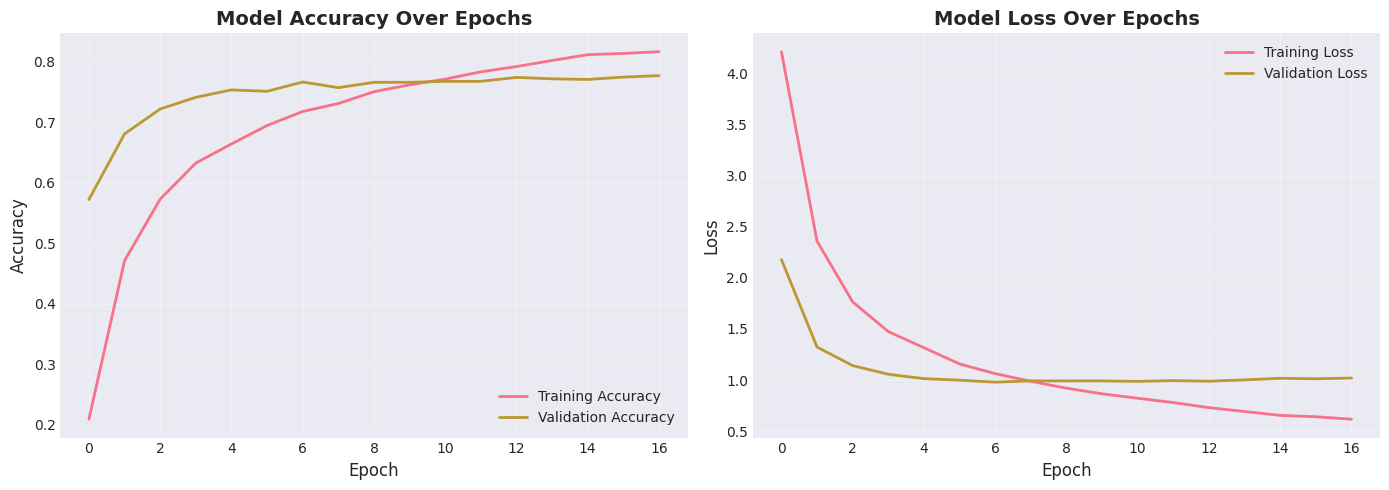


Final ANN Training Metrics:
  Training Accuracy:   0.8168
  Training Loss:       0.6164
  Validation Accuracy: 0.7772
  Validation Loss:     1.0199


In [15]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/ann_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal ANN Training Metrics:")
print(f"  Training Accuracy:   {final_train_acc:.4f}")
print(f"  Training Loss:       {final_train_loss:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Validation Loss:     {final_val_loss:.4f}")

### CNN Model Architecture and Data Preparation

Now we'll build a Convolutional Neural Network (CNN) that works directly with the original image data (without pre-extracted MobileNet features). This allows the network to learn its own visual representations from scratch.

**Key Differences from ANN:**
- **Input**: Raw images (224x224x3) instead of pre-extracted features (1280D)
- **Architecture**: Convolutional layers to detect visual patterns (edges, textures, shapes)
- **Feature Learning**: Learns hierarchical features automatically through convolution and pooling

We'll use data generators to efficiently load and augment images during training.

In [16]:
# Create dataframes for train/val/test with image paths and category labels
train_indices = df_features.iloc[X_train.shape[0] + X_val.shape[0]:].index.tolist()[:len(y_train)]
val_indices = df_features.iloc[len(y_train):len(y_train) + len(y_val)].index.tolist()
test_indices = df_features.iloc[len(y_train) + len(y_val):].index.tolist()

# We need to map back from the split indices so we recreate from original valid_indices
# Since we did train_test_split on the features, we need to track which original samples went where
print("Preparing image data for CNN...")

# Get the original dataframe indices that correspond to our splits
# This requires reconstructing the mapping
temp_indices = list(range(len(features_array)))
train_temp_indices, test_temp_indices = train_test_split(
    temp_indices, test_size=0.15, stratify=y_encoded, random_state=RANDOM_STATE
)
train_final_indices, val_final_indices = train_test_split(
    train_temp_indices, test_size=0.176, stratify=y_encoded[train_temp_indices], random_state=RANDOM_STATE
)

# Create DataFrames for each split
df_train_cnn = df_features.iloc[train_final_indices].copy()
df_val_cnn = df_features.iloc[val_final_indices].copy()
df_test_cnn = df_features.iloc[test_temp_indices].copy()

print(f"CNN Dataset Splits:")
print(f"  Training:   {len(df_train_cnn)} samples")
print(f"  Validation: {len(df_val_cnn)} samples")
print(f"  Test:       {len(df_test_cnn)} samples")

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
CNN_BATCH_SIZE = 32

# Data generators for CNN
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators from dataframes
train_generator = train_datagen.flow_from_dataframe(
    df_train_cnn,
    x_col='image_path',
    y_col='category',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=CNN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_STATE
)

val_generator = val_test_datagen.flow_from_dataframe(
    df_val_cnn,
    x_col='image_path',
    y_col='category',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=CNN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    df_test_cnn,
    x_col='image_path',
    y_col='category',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=CNN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nData generators created successfully!")

Preparing image data for CNN...
CNN Dataset Splits:
  Training:   17899 samples
  Validation: 3824 samples
  Test:       3834 samples
Found 17899 validated image filenames belonging to 233 classes.
Found 3824 validated image filenames belonging to 233 classes.
Found 3834 validated image filenames belonging to 233 classes.

Data generators created successfully!


In [ ]:
# Build CNN Model
def build_patternmind_cnn(input_shape, num_classes):
    """
    Builds a 3-layer Convolutional Neural Network for image classification.
    
    Architecture:
    - Conv Layer 1 (64 filters, 3x3): Learn basic visual features (edges, colors)
    - Conv Layer 2 (128 filters, 3x3): Learn mid-level features (textures, patterns)
    - Conv Layer 3 (256 filters, 3x3): Learn high-level features (object parts)
    - Each conv layer followed by MaxPooling for spatial reduction
    - Dense layers for final classification
    
    Args:
        input_shape: Tuple (height, width, channels)
        num_classes: Number of output categories
    
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential(name="PatternMind_CNN")
    
    # Convolutional Layer 1: Learn basic visual features
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Convolutional Layer 2: Learn mid-level features
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Convolutional Layer 3: Learn high-level features
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flatten to 1D for dense layers
    model.add(Flatten())
    
    # Dense Layer 1: High-level reasoning
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Dense Layer 2: Intermediate reasoning
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer: Classification
    model.add(Dense(num_classes, activation='softmax', name='output_classification'))
    
    return model

# Build the CNN model
cnn_model = build_patternmind_cnn(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=NB_CATEGORIES
)

# Print model summary
cnn_model.summary()

# Compile the model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping for CNN
cnn_es_callback = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

print("\nCNN Model compiled and ready for training!")

Model: "PatternMind_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_classification (Dense)   │ (None, 233)            │        59,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,326,825 (394.16 MB)

 Trainable params: 103,324,905 (394.15 MB)

 Non-trainable params: 1,920 (7.50 KB)


CNN Model compiled and ready for training!


: 

### CNN Training

In [ ]:
# Train the CNN model
print("Starting CNN training...\n")
print("This will take much longer than the ANN as it processes full images...\n")

# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

cnn_history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[cnn_es_callback],
    verbose=1
)

print("\n" + "."*60)
print("CNN Training Complete!")
print("."*60)

Starting CNN training...

This will take much longer than the ANN as it processes full images...

Epoch 1/50


2025-11-12 23:40:15.478972: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:40:15.479038: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:40:15.479108: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:40:15.479121: I external/l

560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.0354 - loss: 6.0329

2025-11-12 23:42:46.746880: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-12 23:42:47.559305: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 12 bytes spill stores, 12 bytes spill loads

2025-11-12 23:42:47.845386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 32 bytes spill stores, 32 bytes spill loads

2025-11-12 23:42:57.408821: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.
2025-11-12 23:42:58.042017: W external/local_xla/x

560/560 ━━━━━━━━━━━━━━━━━━━━ 167s 266ms/step - accuracy: 0.0354 - loss: 6.0323 - val_accuracy: 0.0913 - val_loss: 4.8950
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 130s 231ms/step - accuracy: 0.0727 - loss: 5.1391 - val_accuracy: 0.0813 - val_loss: 4.9425
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1001 - loss: 4.8333

2025-11-12 23:47:16.732806: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.


560/560 ━━━━━━━━━━━━━━━━━━━━ 129s 231ms/step - accuracy: 0.1001 - loss: 4.8333 - val_accuracy: 0.1331 - val_loss: 4.5519
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1146 - loss: 4.6520

2025-11-12 23:49:28.304998: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.


560/560 ━━━━━━━━━━━━━━━━━━━━ 134s 239ms/step - accuracy: 0.1146 - loss: 4.6520 - val_accuracy: 0.1506 - val_loss: 4.3905
Epoch 5/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.1233 - loss: 4.5838

2025-11-12 23:51:44.997452: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.


560/560 ━━━━━━━━━━━━━━━━━━━━ 135s 240ms/step - accuracy: 0.1233 - loss: 4.5837 - val_accuracy: 0.1611 - val_loss: 4.2809
Epoch 6/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 134s 239ms/step - accuracy: 0.1285 - loss: 4.4622 - val_accuracy: 0.1695 - val_loss: 4.2224
Epoch 7/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 130s 232ms/step - accuracy: 0.1407 - loss: 4.3472 - val_accuracy: 0.1352 - val_loss: 4.4374
Epoch 8/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 130s 232ms/step - accuracy: 0.1494 - loss: 4.2681 - val_accuracy: 0.2003 - val_loss: 3.9922
Epoch 9/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 135s 240ms/step - accuracy: 0.1558 - loss: 4.2112 - val_accuracy: 0.1995 - val_loss: 3.9592
Epoch 10/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 137s 245ms/step - accuracy: 0.1620 - loss: 4.1674 - val_accuracy: 0.2006 - val_loss: 3.9394
Epoch 11/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 139s 248ms/step - accuracy: 0.1696 - loss: 4.1033 - val_accuracy: 0.2218 - val_loss: 3.7926
Epoch 12/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 137s 243ms/step - accuracy: 0.1787 - loss: 4

### CNN Training Visualization

In [ ]:
# Visualize CNN training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy
axes[0].plot(cnn_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('CNN Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[1].plot(cnn_history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(cnn_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('CNN Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
cnn_final_train_acc = cnn_history.history['accuracy'][-1]
cnn_final_val_acc = cnn_history.history['val_accuracy'][-1]
cnn_final_train_loss = cnn_history.history['loss'][-1]
cnn_final_val_loss = cnn_history.history['val_loss'][-1]

print(f"\nFinal CNN Training Metrics:")
print(f"  Training Accuracy:   {cnn_final_train_acc:.4f}")
print(f"  Training Loss:       {cnn_final_train_loss:.4f}")
print(f"  Validation Accuracy: {cnn_final_val_acc:.4f}")
print(f"  Validation Loss:     {cnn_final_val_loss:.4f}")

### Model Comparison: ANN vs CNN

Now let's compare the performance of both models side-by-side. We'll examine:
1. **Loss curves**: How quickly each model converges and whether they overfit
2. **Training efficiency**: Which model learns faster
3. **Final performance**: Which approach achieves better accuracy

**Expected Differences:**
- **ANN**: Uses pre-trained MobileNetV2 features, should converge faster
- **CNN**: Learns features from scratch, may need more epochs and will take much more time but could discover task-specific patterns

In [ ]:
# Compare ANN and CNN training histories
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get the minimum number of epochs between both models (in case early stopping differed)
min_epochs_ann = len(history.history['loss'])
min_epochs_cnn = len(cnn_history.history['loss'])

# 1. Training Loss Comparison
axes[0, 0].plot(range(1, min_epochs_ann + 1), history.history['loss'], 
                label='ANN Training Loss', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(range(1, min_epochs_cnn + 1), cnn_history.history['loss'], 
                label='CNN Training Loss', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Validation Loss Comparison
axes[0, 1].plot(range(1, min_epochs_ann + 1), history.history['val_loss'], 
                label='ANN Validation Loss', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(range(1, min_epochs_cnn + 1), cnn_history.history['val_loss'], 
                label='CNN Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Training Accuracy Comparison
axes[1, 0].plot(range(1, min_epochs_ann + 1), history.history['accuracy'], 
                label='ANN Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[1, 0].plot(range(1, min_epochs_cnn + 1), cnn_history.history['accuracy'], 
                label='CNN Training Accuracy', linewidth=2, marker='s', markersize=4)
axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].legend(fontsize=11, loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Validation Accuracy Comparison
axes[1, 1].plot(range(1, min_epochs_ann + 1), history.history['val_accuracy'], 
                label='ANN Validation Accuracy', linewidth=2, marker='o', markersize=4)
axes[1, 1].plot(range(1, min_epochs_cnn + 1), cnn_history.history['val_accuracy'], 
                label='CNN Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].legend(fontsize=11, loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/ann_vs_cnn_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n" + "."*70)
print("MODEL COMPARISON SUMMARY")
print("."*70)

print("\n--- ANN (with MobileNetV2 features) ---")
print(f"  Total Epochs Trained:    {min_epochs_ann}")
print(f"  Final Training Loss:     {history.history['loss'][-1]:.4f}")
print(f"  Final Validation Loss:   {history.history['val_loss'][-1]:.4f}")
print(f"  Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final Val Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
print(f"  Best Validation Loss:    {min(history.history['val_loss']):.4f} (Epoch {np.argmin(history.history['val_loss']) + 1})")
print(f"  Best Val Accuracy:       {max(history.history['val_accuracy']):.4f} (Epoch {np.argmax(history.history['val_accuracy']) + 1})")

print("\n--- CNN (from raw images) ---")
print(f"  Total Epochs Trained:    {min_epochs_cnn}")
print(f"  Final Training Loss:     {cnn_history.history['loss'][-1]:.4f}")
print(f"  Final Validation Loss:   {cnn_history.history['val_loss'][-1]:.4f}")
print(f"  Final Training Accuracy: {cnn_history.history['accuracy'][-1]:.4f}")
print(f"  Final Val Accuracy:      {cnn_history.history['val_accuracy'][-1]:.4f}")
print(f"  Best Validation Loss:    {min(cnn_history.history['val_loss']):.4f} (Epoch {np.argmin(cnn_history.history['val_loss']) + 1})")
print(f"  Best Val Accuracy:       {max(cnn_history.history['val_accuracy']):.4f} (Epoch {np.argmax(cnn_history.history['val_accuracy']) + 1})")

print("\n" + "."*70)
print("INSIGHTS")
print("."*70)

# Determine which model performed better
ann_best_val_acc = max(history.history['val_accuracy'])
cnn_best_val_acc = max(cnn_history.history['val_accuracy'])
ann_best_val_loss = min(history.history['val_loss'])
cnn_best_val_loss = min(cnn_history.history['val_loss'])

if ann_best_val_acc > cnn_best_val_acc:
    print(f"ANN achieved higher validation accuracy ({ann_best_val_acc:.4f} vs {cnn_best_val_acc:.4f})")
else:
    print(f"CNN achieved higher validation accuracy ({cnn_best_val_acc:.4f} vs {ann_best_val_acc:.4f})")

if ann_best_val_loss < cnn_best_val_loss:
    print(f"ANN achieved lower validation loss ({ann_best_val_loss:.4f} vs {cnn_best_val_loss:.4f})")
else:
    print(f"CNN achieved lower validation loss ({cnn_best_val_loss:.4f} vs {ann_best_val_loss:.4f})")

# Check overfitting
ann_overfit = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
cnn_overfit = cnn_history.history['accuracy'][-1] - cnn_history.history['val_accuracy'][-1]

print(f"\nOverfitting Analysis (Train-Val Accuracy Gap):")
print(f"  ANN: {ann_overfit:.4f}")
print(f"  CNN: {cnn_overfit:.4f}")

if ann_overfit < cnn_overfit:
    print(f"ANN shows less overfitting")
else:
    print(f"CNN shows less overfitting")

print("\n" + "."*70)